# Multilevel Bayesian Model for Soccer Match Predictions

This kernel introduces multilevel bayesian modelling with TensorFlow Probability applied to soccer match predictions.  



---
The basically idea of this multilevel model is to model each team, home and away, probability density of score a goal. The final result of the match is, therefore, the difference between scored home and away goals.  

The framework starts by modelling attacking and defense rate for each team, but tries to consider a home advantage for the home team. Therefore, the model assumptions are the following:

The purpose of this work is to model the posterior distribution of home and away goals for each match as follows:

**likelihoods**
\begin{align}
homegoals &\sim Poisson(\exp{(homediff)}) \\
awaygoals &\sim Poisson(\exp{(awaydiff)})
\end{align}


**priors**
\begin{align}
homediff &= AttRate_{home} - DefRate_{away} + HomeAttAdvantage_{home} \\
awaydiff &= AttRate_{away} - DefRate_{home} - HomeDefAdvantage_{home} \\
\end{align}  


**atack rate**
\begin{align}
AttRate_i &= BaseAtt + AttRate_{i, non-centered} * \tau^{att}_i \\
BaseAtt &\sim Normal(0, 1) \\
AttRate_i &\sim Normal(0, 1) \\
\tau^{att}_i &\sim Gamma(2, 2) \\
\end{align} 

**defense rate**
\begin{align}
DefRate_i &= DefRate_{i, non-centered} * \tau^{def}_i \\
DefRate_i &\sim Normal(0, 1) \\ 
\tau^{def}_i &\sim Gamma(2, 2) \\
\end{align} 

**home attacking advantage**
\begin{align}
HomeAttAdvantage_{home} &= BaseHomeAtt + HomeAttRate_{i, non-centered} * \tau^{HomeAtt}_i \\
BaseHomeAtt &\sim Normal(0, 1) \\
HomeAttRate_i &\sim Normal(0, 1) \\
\tau^{HomeAtt}_i &\sim Gamma(2, 2) \\
\end{align} 

**home defense advantage**
\begin{align}
HomeDefAdvantage_{home} &= BaseHomeDef + HomeDefRate_{i, non-centered} * \tau^{HomeDef}_i \\
BaseHomeDef &\sim Normal(0, 1) \\
HomeDefRate_i &\sim Normal(0, 1) \\
\tau^{HomeDef}_i &\sim Gamma(2, 2) \\
\end{align}

where $i = 1, \dots, n$, where $n$ is the number of teams playing the league (usually 20)

---

## Coding

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.auto import tqdm

tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

### Read SQL Data 

In [2]:
# data is stored in SQL DB, so we need to establish a connection with it
# let's use SQLite3 and Pandas for it

# create engine for connection
engine = sqlite3.connect('/soccer/database.sqlite')

# connect and get dfs
matches = pd.read_sql_query('SELECT * FROM Match', con=engine)
teams = pd.read_sql_query('SELECT * FROM Team', con=engine)
countries = pd.read_sql_query('SELECT * FROM Country', con=engine)

In [3]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,...,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [4]:
teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [5]:
countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [6]:
# let's merge all dataframes
df = pd.merge(matches, teams, left_on=['home_team_api_id'], right_on=['team_api_id'])
df = df.merge(teams, left_on=['away_team_api_id'], right_on=['team_api_id'],
              suffixes=('_home', '_away'))
df = df.merge(countries, left_on=['country_id'], right_on=['id'])

df.sample(5)

,id_x,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,...,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,id_y,team_api_id_home,team_fifa_api_id_home,team_long_name_home,team_short_name_home,id_x,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away,id_y,name
6919,5827,4769,4769,2010/2011,36,2011-05-15 00:00:00,830520,9853,9851,1,2,1.0,2.0,4.0,6.0,8.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,2.0,4.0,...,3.30,2.2,3.20,3.50,2.25,3.00,3.40,2.20,3.10,3.2,2.25,3.10,3.20,9556,9853,1819.0,AS Saint-Étienne,ETI,9551,9851,74.0,Stade Rennais FC,REN,4769,France
19551,19585,17642,17642,2015/2016,29,2016-04-10 00:00:00,2016069,188163,6367,1,0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,2.0,4.0,...,2.90,NaN,NaN,NaN,2.30,3.25,3.30,NaN,NaN,NaN,NaN,NaN,NaN,38791,188163,NaN,Tondela,TON,38789,6367,NaN,Uniao da Madeira,MAD,17642,Portugal
23650,22200,21518,21518,2009/2010,37,2010-05-08 00:00:00,685185,10281,8696,2,1,1.0,2.0,4.0,6.0,8.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,2.0,4.0,...,3.20,2.1,3.40,3.40,2.00,3.25,3.60,2.05,3.40,3.4,2.00,3.30,3.40,43050,10281,462.0,Real Valladolid,VAL,43043,8696,456.0,Racing Santander,SAN,21518,Spain
2519,1912,1729,1729,2008/2009,26,2009-02-21 00:00:00,489296,10252,8455,0,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,...,2.20,3.0,3.25,2.38,3.10,3.25,2.25,3.20,3.25,2.2,3.40,3.20,2.25,3465,10252,2.0,Aston Villa,AVL,3475,8455,5.0,Chelsea,CHE,1729,England
24433,22184,21518,21518,2009/2010,35,2010-05-01 00:00:00,685162,8558,10267,0,2,1.0,2.0,4.0,6.0,8.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,2.0,4.0,...,2.38,3.0,3.25,2.38,2.88,3.25,2.38,2.85,3.25,2.4,2.88,3.25,2.38,43049,8558,452.0,RCD Espanyol,ESP,43035,10267,461.0,Valencia CF,VAL,21518,Spain


### Selecting a league to work on

Let's select Italian's Serie A League, season 2015/2016, just to illustrate how the model works.

We will model the 1st leg of each match (i.e. 19 rounds/matches) and predict the second.

In [7]:
def get_league_year_data(df, season, country):
    mask_league = df.season == season
    mask_country = df.name == country
    return df.loc[mask_league & mask_country].reset_index(drop=True)

In [8]:
# params
season = '2015/2016'
country = 'Italy'
df_italy = get_league_year_data(df, season, country)

df_italy.sample(5)

,id_x,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,...,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,id_y,team_api_id_home,team_fifa_api_id_home,team_long_name_home,team_short_name_home,id_x,team_api_id_away,team_fifa_api_id_away,team_long_name_away,team_short_name_away,id_y,name
172,13187,10257,10257,2015/2016,36,2016-04-30 00:00:00,2060597,8533,8535,0,0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,5.0,4.0,6.0,1.0,3.0,5.0,...,2.00,NaN,NaN,NaN,4.10,3.3,2.05,NaN,NaN,NaN,NaN,NaN,NaN,20519,8533,192.0,Chievo Verona,CHI,20521,8535,110374.0,Fiorentina,FIO,10257,Italy
371,12914,10257,10257,2015/2016,11,2015-11-01 00:00:00,2060464,9857,8524,3,0,1.0,4.0,6.0,8.0,2.0,3.0,5.0,7.0,7.0,3.0,5.0,1.0,2.0,4.0,...,2.70,NaN,NaN,NaN,3.00,3.0,2.70,NaN,NaN,NaN,NaN,NaN,NaN,20524,9857,189.0,Bologna,BOL,20513,8524,39.0,Atalanta,ATA,10257,Italy
205,13148,10257,10257,2015/2016,32,2016-04-09 00:00:00,2060518,7943,10233,0,1,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,3.0,5.0,...,3.75,NaN,NaN,NaN,2.00,3.3,4.20,NaN,NaN,NaN,NaN,NaN,NaN,24288,7943,111974.0,Sassuolo,SAS,20518,10233,110556.0,Genoa,GEN,10257,Italy
289,13017,10257,10257,2015/2016,20,2016-01-17 00:00:00,2060289,8686,9876,1,1,1.0,2.0,4.0,6.0,8.0,4.0,6.0,3.0,5.0,7.0,5.0,1.0,3.0,5.0,...,8.00,NaN,NaN,NaN,1.33,5.0,10.50,NaN,NaN,NaN,NaN,NaN,NaN,20525,8686,52.0,Roma,ROM,24273,9876,206.0,Hellas Verona,VER,10257,Italy
106,13165,10257,10257,2015/2016,34,2016-04-19 00:00:00,2060555,9875,9857,6,0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,2.0,4.0,...,13.00,NaN,NaN,NaN,1.22,6.5,15.00,NaN,NaN,NaN,NaN,NaN,NaN,20526,9875,48.0,Napoli,NAP,20524,9857,189.0,Bologna,BOL,10257,Italy


Our training data will be first leg of each match, i.e. up to round 19 (or stage 19)

In [9]:
def get_training_data(df_season, stage):
    mask_stage = df_season.stage <= stage
    return df_season.loc[mask_stage]

# params
training_stage = 19
df_train = get_training_data(df_italy, training_stage)

# check max stage
df_train.stage.max() # 19

19

## Partial standings

In [10]:
# let's have a look at partial standings up to stage 19
def get_standing(df_season, partial=None):
    '''function to calculate (partial) standings.
    If `partial` params is passed, then the standing is calculated up to that stage.
    
    Win: 3pts
    Draw: 1pt
    Lose: 0pt
    '''
    aux = df_season.copy()
    if partial is not None:
        aux = aux.loc[aux.stage <= partial]
    # create flag for each results, home and away
    aux['home_win'] = aux['home_team_goal'] > aux['away_team_goal'] # home win
    aux['draw'] = aux['home_team_goal'] == aux['away_team_goal'] # draw
    aux['away_win'] = aux['home_team_goal'] < aux['away_team_goal'] # away win
    
    # columns for standings
    # we will groupby team and count home and away performance
    rename_home = {
        'team_long_name_home': 'Team',
        'home_team_goal': 'H-GF', # home goals for
        'away_team_goal': 'H-GA', # home goals against
        'home_win': 'H-W',        # home wins
        'draw': 'H-D',            # home draws
        'away_win': 'H-L',        # home losses
        'stage': 'H-Played',      # home played
    }
    # away is inverted
    rename_away = {
        'team_long_name_away': 'Team',
        'home_team_goal': 'A-GA', # away goals for
        'away_team_goal': 'A-GF', # away goals against
        'home_win': 'A-L',        # away wins
        'draw': 'A-D',            # away draws
        'away_win': 'A-W',        # away losses
        'stage': 'A-Played',      # away played
    }
    # agg to calculate (all sums except played that is count)
    home_agg = {col: 'sum' for col in rename_home.values() 
                if 'Played' not in col 
                if 'Team' not in col}
    home_agg['H-Played'] = 'count'
    away_agg = {col: 'sum' for col in rename_away.values() 
                if 'Played' not in col 
                if 'Team' not in col}
    away_agg['A-Played'] = 'count'
    # generating DFs
    home_tmp = aux.rename(columns=rename_home).groupby('Team').agg(home_agg).astype(int)
    away_tmp = aux.rename(columns=rename_away).groupby('Team').agg(away_agg).astype(int)
    # adding partial results
    standings = pd.concat([home_tmp, away_tmp], axis=1)
    # get overall stats
    standings['Played'] = standings['H-Played'] + standings['A-Played']
    standings['W'] = standings['H-W'] + standings['A-W']
    standings['D'] = standings['H-D'] + standings['A-D']
    standings['L'] = standings['H-L'] + standings['A-L']
    # goals
    standings['GF'] = standings['H-GF'] + standings['A-GF']
    standings['GA'] = standings['H-GA'] + standings['A-GA']
    # goals diff
    standings['H-GD'] = standings['H-GF'] + standings['H-GA']
    standings['A-GD'] = standings['A-GF'] + standings['A-GA']
    standings['GD'] = standings['H-GD'] + standings['A-GD']
    # points
    standings['H-Pts'] = standings['H-W'] * 3 + standings['H-D'] * 1
    standings['A-Pts'] = standings['A-W'] * 3 + standings['A-D'] * 1
    standings['Pts'] = standings['H-Pts'] + standings['A-Pts']
    # sort by pts, then Wins, then GF
    cols_order = ['Pts', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD',
                  'H-Pts', 'H-Played', 'H-W', 'H-D', 'H-L', 'H-GF', 'H-GA', 'H-GD',
                  'A-Pts', 'A-Played', 'A-W', 'A-D', 'A-L', 'A-GF', 'A-GA', 'A-GD',]
    return standings.sort_values(by=['Pts', 'W', 'GF'], ascending=False)[cols_order]

In [11]:
get_standing(df_italy, 19)

,Pts,Played,W,D,L,GF,GA,GD,H-Pts,H-Played,H-W,H-D,H-L,H-GF,H-GA,H-GD,A-Pts,A-Played,A-W,A-D,A-L,A-GF,A-GA,A-GD
Team,,,,,,,,,,,,,,,,,,,,,,,,
Napoli,41,19,12,5,2,38,15,53,23,9,7,2,0,18,6,24,18,10,5,3,2,20,9,29
Juventus,39,19,12,3,4,33,15,48,20,9,6,2,1,16,6,22,19,10,6,1,3,17,9,26
Inter,39,19,12,3,4,24,12,36,19,10,6,1,3,11,7,18,20,9,6,2,1,13,5,18
Fiorentina,38,19,12,2,5,37,19,56,22,10,7,1,2,21,8,29,16,9,5,1,3,16,11,27
Roma,34,19,9,7,3,36,22,58,20,9,6,2,1,20,9,29,14,10,3,5,2,16,13,29
Sassuolo,32,19,8,8,3,24,18,42,17,9,4,5,0,13,9,22,15,10,4,3,3,11,9,20
Empoli,30,19,9,3,7,24,23,47,13,9,4,1,4,11,10,21,17,10,5,2,3,13,13,26
Milan,29,19,8,5,6,25,23,48,17,9,5,2,2,13,11,24,12,10,3,3,4,12,12,24
Lazio,27,19,8,3,8,23,27,50,18,10,5,3,2,14,8,22,9,9,3,0,6,9,19,28


# Modelling

### Label Encode

In [12]:
# we should first label encode the teams
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(np.concatenate((df_train['team_long_name_home'].unique(), 
                       df_train['team_long_name_away'].unique())))

df_train['home_team_new_id'] = le.transform(df_train['team_long_name_home'])
df_train['away_team_new_id'] = le.transform(df_train['team_long_name_away'])

In [13]:
home_team = df_train['home_team_new_id'].values
away_team = df_train['away_team_new_id'].values
home_score = tf.cast(df_train['home_team_goal'], tf.float32)
away_score = tf.cast(df_train['away_team_goal'], tf.float32)
scores = (home_score, away_score)
num_home_teams = df_train['team_long_name_home'].nunique()
num_away_teams = df_train['team_long_name_away'].nunique()

### Model with TFP

In [14]:


Root = tfd.JointDistributionCoroutine.Root
def model():  # <== need to be a model with no input and no return
    # Home attack rate
    attack_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
    attack_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
    attack_rate_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
    attack_rate = attack_hyper + attack_rate_nc * attack_hyper_sd
    # Away defense rate
    defense_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
    defense_rate_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_away_teams))
    defense_rate = defense_rate_nc * defense_hyper_sd
    # Home attack advantage
    home_attack_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
    home_attack_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
    home_attack_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
    home_attack_advantage = home_attack_hyper + home_attack_nc * home_attack_hyper_sd
    # Home defense advantage
    home_defense_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
    home_defense_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
    home_defense_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
    home_defense_advantage = home_defense_hyper + home_defense_nc * home_defense_hyper_sd
    # Likelihood
    home_diff = tf.gather(attack_rate, home_team, axis=-1) - \
              tf.gather(defense_rate, away_team, axis=-1) + \
              tf.gather(home_attack_advantage, home_team, axis=-1)

    away_diff = tf.gather(attack_rate, away_team, axis=-1) - \
              tf.gather(defense_rate, home_team, axis=-1) - \
              tf.gather(home_defense_advantage, home_team, axis=-1)
    home_goals = yield tfd.Independent(tfd.Poisson(log_rate=home_diff), 1)
    away_goals = yield tfd.Independent(tfd.Poisson(log_rate=away_diff), 1)
  
model_jd = tfd.JointDistributionCoroutine(model)

## Inference Prep

In [15]:
# we need log prob for running MCMC chains
unnomarlized_log_prob = lambda *args: model_jd.log_prob(list(args) + [
    home_score[tf.newaxis, ...], away_score[tf.newaxis, ...]])

# number of parallel chains
num_chains = 5

# initial states (random samples from model)
initial_state = model_jd.sample(num_chains)[:-2] # except last two, which we are estimating

In [16]:
# space constraints
# identity (no constraint) for all rate params
# exp for standard deviations params (tau), since it must be positive
unconstraining_bijectors = [
  tfb.Identity(),
  tfb.Exp(),
  tfb.Identity(),
  tfb.Exp(),
  tfb.Identity(),
  tfb.Exp(),
  tfb.Identity(),
  tfb.Identity(),
  tfb.Exp(),
  tfb.Identity(),
  tfb.Identity(),
]

In [17]:
@tf.function(autograph=False)
def run_chain(init_state, step_size, number_of_steps=1000, burnin=50):

  def trace_fn(_, pkr):
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )
  unrolled_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
      tfp.mcmc.TransformedTransitionKernel(
          inner_kernel=tfp.mcmc.NoUTurnSampler(
              target_log_prob_fn=unnomarlized_log_prob,
              step_size=step_size),
          bijector=unconstraining_bijectors),
    num_adaptation_steps=burnin,
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(  # pylint: disable=g-long-lambda
        inner_results=pkr.inner_results._replace(step_size=new_step_size)
    ),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )

  # Sampling from the chain.
  mcmc_trace, sampler_stats = tfp.mcmc.sample_chain(
      num_results=number_of_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=unrolled_kernel,
      trace_fn=trace_fn)
  return mcmc_trace, sampler_stats

### MCMC

In [18]:
%%time
# params
nchain_adapt = 100
initial_state = list(model_jd.sample(num_chains)[:-2])

number_of_steps = 2000
burnin = 500
init_step_size = [tf.ones_like(x) for x in initial_state]

# mcmc
mcmc_trace, sampler_stats = run_chain(initial_state, init_step_size, 
                                      number_of_steps, burnin)

CPU times: user 51min 13s, sys: 10min 26s, total: 1h 1min 39s
Wall time: 38min 59s


## Analysis

In [19]:
# forest plots
def forest_plot(num_chains, num_vars, var_name, var_labels, samples):
    fig, axes = plt.subplots(
        1, 2, figsize=(12, 15), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    for var_idx in range(num_vars):
        values = samples[..., var_idx]
        rhat = tfp.mcmc.diagnostic.potential_scale_reduction(values).numpy()
        meds = np.median(values, axis=-2)
        los = np.percentile(values, 5, axis=-2)
        his = np.percentile(values, 95, axis=-2)

        for i in range(num_chains):
            height = 0.0 + var_idx + 0.05 * i
            axes[0].plot([los[i], his[i]], [height, height], 'C0-', lw=2, alpha=0.5)
            axes[0].plot([meds[i]], [height], 'C0o', ms=1.5)
        axes[1].plot([rhat], [height], 'C0o', ms=4)

    axes[0].set_yticks(np.arange(0, num_vars))
    axes[0].set_ylim(0, num_vars)
    axes[0].grid(which='both')
    axes[0].invert_yaxis()
    axes[0].set_yticklabels(var_labels)
    axes[0].xaxis.set_label_position('top')
    axes[0].set(xlabel='95% Credible Intervals for {}'.format(var_name))

    axes[1].set_xticks([1, 2])
    axes[1].set_xlim(0.95, 2.05)
    axes[1].grid(which='both')
    axes[1].set(xlabel='R-hat')
    axes[1].xaxis.set_label_position('top')

    plt.show()

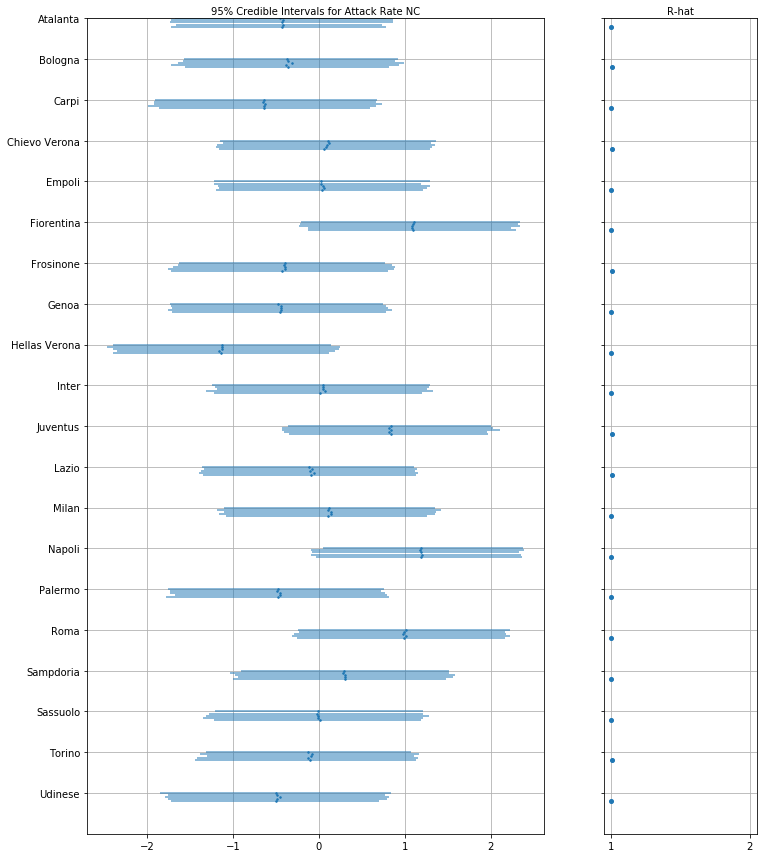

In [20]:
forest_plot(num_chains, len(le.classes_), 'Attack Rate NC', le.classes_, mcmc_trace[2])

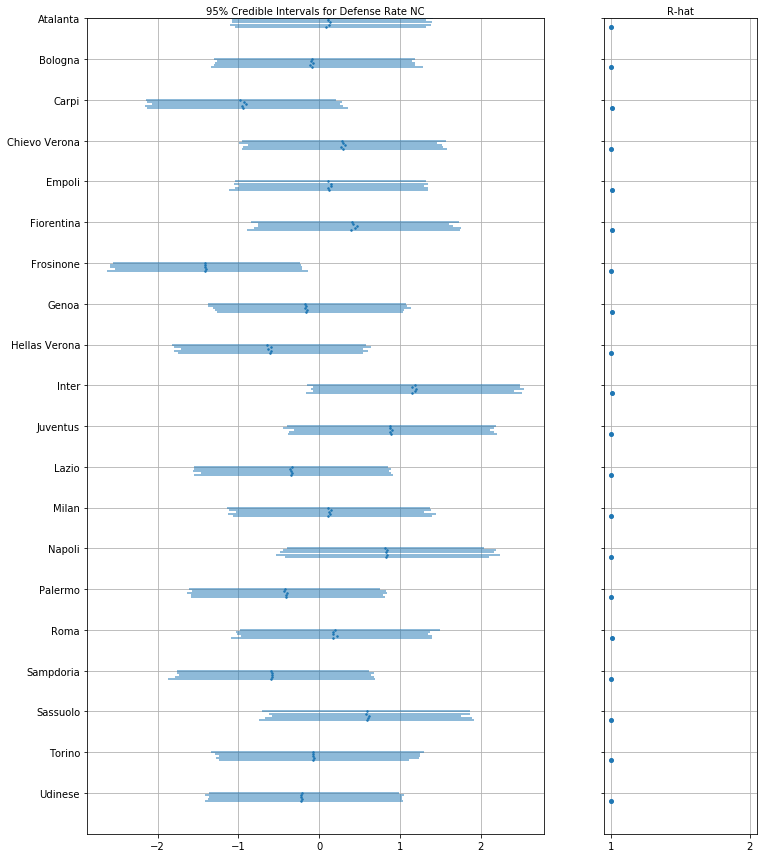

In [21]:
forest_plot(num_chains, len(le.classes_), 'Defense Rate NC', le.classes_, mcmc_trace[4])

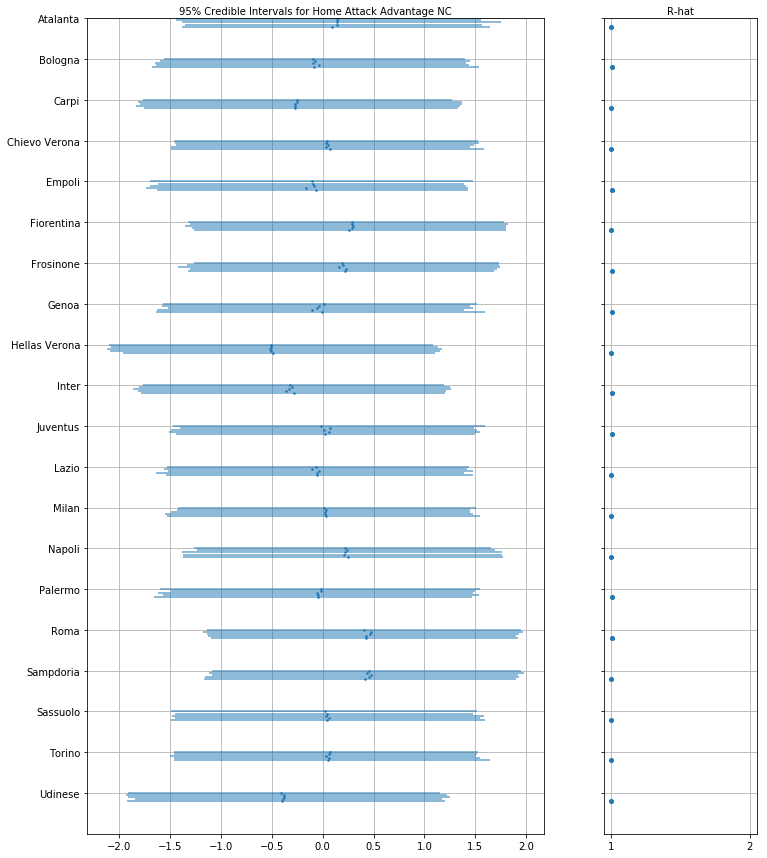

In [22]:
forest_plot(num_chains, len(le.classes_), 'Home Attack Advantage NC', le.classes_, mcmc_trace[7])

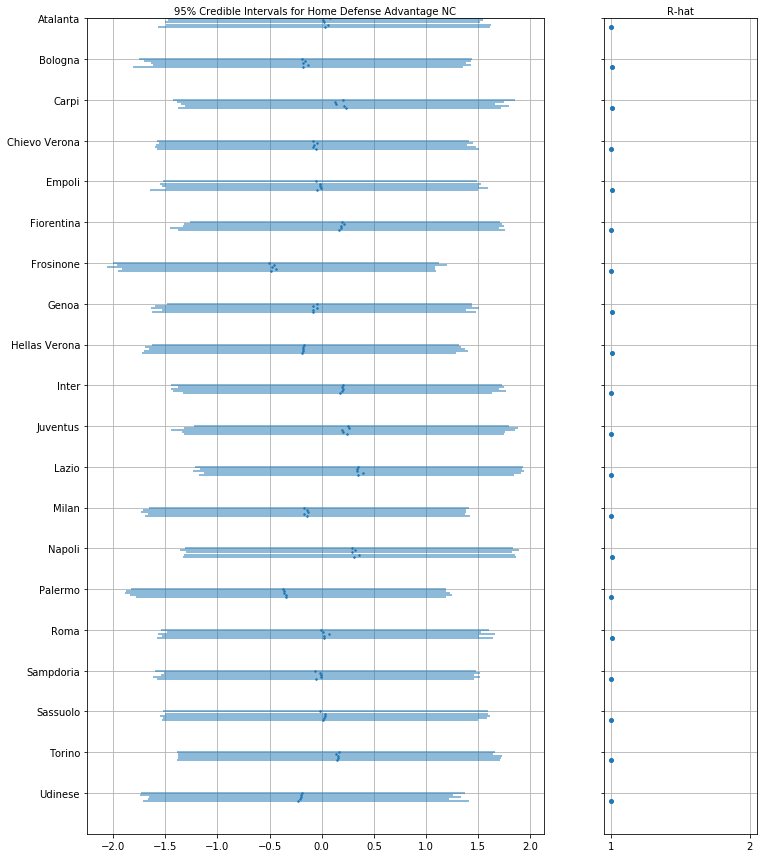

In [23]:
forest_plot(num_chains, len(le.classes_), 'Home Defense Advantage NC', le.classes_, mcmc_trace[10])

## Predictions

Now that we are satisfied with our estimated parameters, let's run predictions from all remaining games.

It is worth noticing that is a prediction with estimated parameters up to round 19, but in practice, the parameters should be updated at every match or round and so the predictions.

### Map "future" matches

In [24]:
# we need a df with future matches and properly encoded teams
df_future = df_italy.loc[df_italy.stage > 19]

# encode
df_future['home_team_new_id'] = le.transform(df_future['team_long_name_home'])
df_future['away_team_new_id'] = le.transform(df_future['team_long_name_away'])

# bookkeeping
home_team_future = df_future['home_team_new_id'].values
away_team_future = df_future['away_team_new_id'].values

## Create "Future Model"  
this model is just the workaround to run posterior predictive, i.e. generate future match results given the trace previously estimated

In [25]:
# future model
# we only need to change the last two parameters, which now receive future matches home and away team codes

def future_model():  # <== need to be a model with no input and no return
  # Home attack rate
  attack_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
  attack_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
  attack_rate_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
  attack_rate = attack_hyper + attack_rate_nc * attack_hyper_sd
  # Away defense rate
  defense_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
  defense_rate_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_away_teams))
  defense_rate = defense_rate_nc * defense_hyper_sd
  # Home attack advantage
  home_attack_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
  home_attack_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
  home_attack_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
  home_attack_advantage = home_attack_hyper + home_attack_nc * home_attack_hyper_sd
  # Home defense advantage
  home_defense_hyper_sd = yield Root(tfd.Sample(tfd.Gamma(concentration=2., rate=2.), 1))
  home_defense_hyper = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), 1))
  home_defense_nc = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), num_home_teams))
  home_defense_advantage = home_defense_hyper + home_defense_nc * home_defense_hyper_sd
  # Likelihood (this is what is changed, so that tf.gather works as expected)
  home_diff = tf.gather(attack_rate, home_team_future, axis=-1) - \
              tf.gather(defense_rate, away_team_future, axis=-1) + \
              tf.gather(home_attack_advantage, home_team_future, axis=-1)

  away_diff = tf.gather(attack_rate, away_team_future, axis=-1) - \
              tf.gather(defense_rate, home_team_future, axis=-1) - \
              tf.gather(home_defense_advantage, home_team_future, axis=-1)
  home_goals = yield tfd.Independent(tfd.Poisson(log_rate=home_diff), 1)
  away_goals = yield tfd.Independent(tfd.Poisson(log_rate=away_diff), 1)
  
future_model_jd = tfd.JointDistributionCoroutine(future_model)

## Posterior Predictive

In [26]:
%%time
# posterior predictive given mcmc trace
dists, _ = future_model_jd.sample_distributions(value=mcmc_trace)
# take only the last two (home and away goals)
home_goals_future, away_goals_future = dists[-2], dists[-1]

CPU times: user 488 ms, sys: 4 ms, total: 492 ms
Wall time: 260 ms


In [27]:
# sample from taken distributions
# the shape from a single sample() pass is shape=(2000, 5, 190)
# so, we essentially have 2k * 5 = 10k samples for each of the remaining 190 matches (10 matches per round * 19 rounds)
home_goals_pred = home_goals_future.sample()
away_goals_pred = away_goals_future.sample()

In [28]:
home_goals_pred.shape

TensorShape([2000, 5, 190])

## Results

In [29]:
# generate dataframe with results
from scipy import stats

# probability of each result (mean over all chains, which)
df_future['proba_home'] = (tf.sign(home_goals_pred - away_goals_pred) == 1).numpy().mean(axis=(0, 1))
df_future['proba_draw'] = (tf.sign(home_goals_pred - away_goals_pred) == 0).numpy().mean(axis=(0, 1))
df_future['proba_away'] = (tf.sign(home_goals_pred - away_goals_pred) == -1).numpy().mean(axis=(0, 1))

In [30]:
cols_to_display = ['stage', 'date', 
                   'team_long_name_home',
                   'team_long_name_away',
                   'proba_home', 'proba_draw', 'proba_away']
df_future[cols_to_display].head(10)

,stage,date,team_long_name_home,team_long_name_away,proba_home,proba_draw,proba_away
2,27,2016-02-29 00:00:00,Fiorentina,Napoli,0.4350,0.2500,0.3150
4,35,2016-04-25 00:00:00,Roma,Napoli,0.4193,0.2451,0.3356
5,21,2016-01-24 00:00:00,Sampdoria,Napoli,0.3266,0.2304,0.4430
6,37,2016-05-08 00:00:00,Torino,Napoli,0.3116,0.2605,0.4279
7,31,2016-04-03 00:00:00,Udinese,Napoli,0.2490,0.2568,0.4942
8,29,2016-03-13 00:00:00,Palermo,Napoli,0.2450,0.2458,0.5092
9,23,2016-02-03 00:00:00,Lazio,Napoli,0.2965,0.2550,0.4485
10,25,2016-02-13 00:00:00,Juventus,Napoli,0.4336,0.2539,0.3125
12,33,2016-04-16 00:00:00,Inter,Napoli,0.3777,0.2837,0.3386
22,30,2016-03-20 00:00:00,Milan,Lazio,0.4852,0.2516,0.2632


We essentially have 10k competitions simulated. Let's what are the final standings distributions.

In [31]:
# get numpy preds
home_goals_pred_np = home_goals_pred.numpy().reshape(-1, 190)
away_goals_pred_np = away_goals_pred.numpy().reshape(-1, 190)

**Example of simulated competition**

In [32]:
# example of simulated competition 
def get_simulated_competition(df_1, df_2, preds, simulation_ix=10):
    # re
    df_1_nodup = df_1.loc[:,~df_1.columns.duplicated()]
    df_2_nodup = df_2.loc[:,~df_2.columns.duplicated()]
    # stage preds
    df_2_nodup['home_team_goal'] = preds[0][simulation_ix] # home
    df_2_nodup['away_team_goal'] = preds[1][simulation_ix] # away
    
    full_df = pd.concat([df_1_nodup, df_2_nodup], axis=0, 
                        ignore_index=True, sort=False)
    final_standing = get_standing(full_df)
    
    return final_standing

get_simulated_competition(df_train, df_future, (home_goals_pred_np, away_goals_pred_np))

,Pts,Played,W,D,L,GF,GA,GD,H-Pts,H-Played,H-W,H-D,H-L,H-GF,H-GA,H-GD,A-Pts,A-Played,A-W,A-D,A-L,A-GF,A-GA,A-GD
Team,,,,,,,,,,,,,,,,,,,,,,,,
Napoli,80,38,24,8,6,75,31,106,44,19,14,2,3,39,15,54,36,19,10,6,3,36,16,52
Juventus,76,38,22,10,6,70,33,103,41,19,12,5,2,36,15,51,35,19,10,5,4,34,18,52
Inter,73,38,21,10,7,56,29,85,35,19,10,5,4,29,16,45,38,19,11,5,3,27,13,40
Fiorentina,70,38,20,10,8,65,34,99,40,19,12,4,3,36,14,50,30,19,8,6,5,29,20,49
Sassuolo,66,38,18,12,8,41,35,76,37,19,10,7,2,23,17,40,29,19,8,5,6,18,18,36
Atalanta,62,38,18,8,12,48,42,90,35,19,10,5,4,28,17,45,27,19,8,3,8,20,25,45
Roma,61,38,16,13,9,58,39,97,39,19,12,3,4,34,16,50,22,19,4,10,5,24,23,47
Sampdoria,59,38,17,8,13,71,52,123,36,19,11,3,5,45,23,68,23,19,6,5,8,26,29,55
Milan,57,38,17,6,15,52,51,103,29,19,9,2,8,26,28,54,28,19,8,4,7,26,23,49


In [33]:
def get_simulated_standing_dist(df_1, df_2, preds, n_simulations=10):
    # placeholder
    sim_results = pd.DataFrame()
    for sim in tqdm(range(n_simulations)):
        # get standing
        final_standing_sim = get_simulated_competition(
            df_1, df_2, preds, simulation_ix=sim)
        final_standing_sim['position'] = np.arange(1, len(le.classes_)+1) # positions in order
        final_standing_sim['sim_number'] = sim                            # sim_number
        # concat with results df by index
        sim_results = sim_results.append(final_standing_sim[['position', 'sim_number']])
    
    return sim_results

In [34]:
simulations = get_simulated_standing_dist(
    df_train, df_future, (home_goals_pred_np, away_goals_pred_np),
    n_simulations=10000)

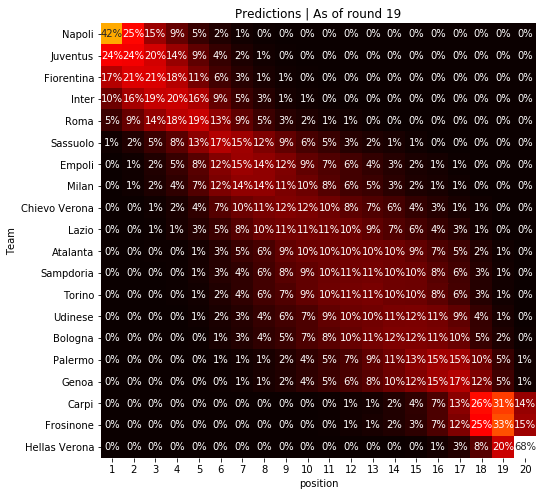

In [35]:
# source: http://gijskoot.nl/bayesian/sports/soccer/predictions/pymc3/2018/02/07/knvb-model.html
rankings_agg = simulations.reset_index().groupby('Team').position.value_counts(normalize=True).unstack(1).fillna(0)
rankings_agg = rankings_agg.assign(expected=rankings_agg @ np.arange(len(le.classes_) + 1, 1, -1))\
    .sort_values("expected", ascending=False).drop("expected", axis = "columns")

plt.figure(figsize=(12, 8))
sns.heatmap(rankings_agg, annot=True, fmt=".0%", cbar=False, cmap="hot", square=True)
plt.title('Predictions | As of round 19');

The rankings probabilities are very spread out, as expected, since there is half tournament to go.

**Actual final standing**

In [36]:
get_standing(df_italy)

,Pts,Played,W,D,L,GF,GA,GD,H-Pts,H-Played,H-W,H-D,H-L,H-GF,H-GA,H-GD,A-Pts,A-Played,A-W,A-D,A-L,A-GF,A-GA,A-GD
Team,,,,,,,,,,,,,,,,,,,,,,,,
Juventus,91,38,29,4,5,75,20,95,50,19,16,2,1,37,6,43,41,19,13,2,4,38,14,52
Napoli,82,38,25,7,6,80,32,112,51,19,16,3,0,49,12,61,31,19,9,4,6,31,20,51
Roma,80,38,23,11,4,83,41,124,44,19,13,5,1,44,17,61,36,19,10,6,3,39,24,63
Inter,67,38,20,7,11,50,38,88,41,19,13,2,4,29,15,44,26,19,7,5,7,21,23,44
Fiorentina,64,38,18,10,10,60,42,102,38,19,11,5,3,34,16,50,26,19,7,5,7,26,26,52
Sassuolo,61,38,16,13,9,49,40,89,32,19,8,8,3,25,20,45,29,19,8,5,6,24,20,44
Milan,57,38,15,12,11,49,43,92,33,19,9,6,4,28,22,50,24,19,6,6,7,21,21,42
Lazio,54,38,15,9,14,52,52,104,33,19,10,3,6,32,23,55,21,19,5,6,8,20,29,49
Chievo Verona,50,38,13,11,14,43,45,88,29,19,7,8,4,25,18,43,21,19,6,3,10,18,27,45


---
Please feel free to reach me out in case of any doubts and for any suggestion.  